In [2]:
### This notebook gives the kernel estimated CDF function
### Author: Yiyun
import sys
sys.path.insert(0, '/storage/work/y/yur97/statsmodels')
import pkg_resources
pkg_resources.require("statsmodels==0.13.0.dev0+523.g6123002")
from statsmodels.nonparametric.kernels_asymmetric import pdf_kernel_asym

import pandas as pd
import os, pickle
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
# import statsmodels.api as sm
import numpy as np

In [3]:
### Read files
dir_p = './figure4/p-val_distribution'
feature_type = 'histology';
syn_nsyn = 'syn'; run = 'cohort_072221'; threshold = 1

df_all = pd.read_csv(os.path.join(dir_p,feature_type+'.'+syn_nsyn+'.df_all_forFDR.'+run+'.'+str(threshold)+'.csv'), index_col = 0)

In [4]:
df_exp = df_all[df_all['exp/nonexp'] == 'exp'];df_nexp = df_all[df_all['exp/nonexp'] == 'nonexp']

In [18]:
x = np.sort(np.random.choice(df_nexp['p'],2000))

In [19]:
out = pdf_kernel_asym(x,x,bw =0.001, kernel_type = 'beta', batch_size = 100000) 

In [22]:
ecdf = ECDF(out)

In [23]:
ecdf

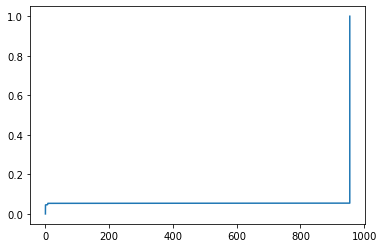

In [26]:
plt.plot(ecdf.x, ecdf.y)

In [17]:
df_nexp['p']

599544    0.001561
599545    0.004460
599546    0.005963
599547    0.020246
599548    0.027505
            ...   
634420    1.000000
634421    1.000000
634422    1.000000
634423    1.000000
634424    1.000000
Name: p, Length: 34881, dtype: float64

In [8]:
ecdf = ECDF(df_all['p'])

In [20]:
ecdf(0.99)

0.09272333215116049

In [31]:
ecdf.x[ecdf.x < 1]

array([     -inf, 0.       , 0.       , ..., 0.9999999, 0.9999999,
       0.9999999])

In [32]:
ecdf.y[ecdf.x<1]

array([0.00000000e+00, 1.57623044e-06, 3.15246089e-06, ...,
       9.44398471e-02, 9.44414233e-02, 9.44429996e-02])

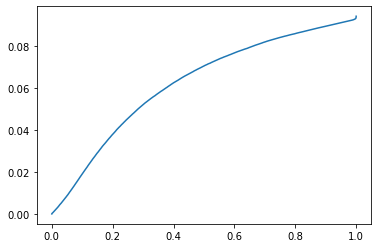

In [33]:
plt.plot(ecdf.x[ecdf.x < 1], ecdf.y[ecdf.x<1])

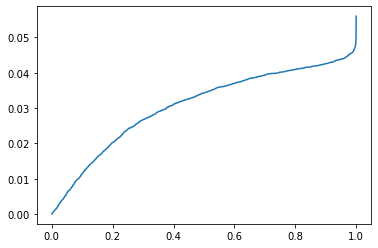

In [9]:
ecdf_h0 = ECDF(df_nexp['p'])
plt.plot(ecdf_h0.x[ecdf_h0.x < 1], ecdf_h0.y[ecdf_h0.x<1])

In [54]:
tf_h0_x = np.log10(ecdf_h0.x)

<ipython-input-54-6d0cb716eeae>:1: RuntimeWarning: invalid value encountered in log10
  tf_h0_x = np.log10(ecdf_h0.x)


In [61]:
kde = sm.nonparametric.KDEUnivariate(ecdf_h0.x[ecdf_h0.x < 1])
kde.fit(bw = 0.000001) # Estimate the densities

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-bzb/lib/python3.8/site-packages/statsmodels/nonparametric/kde.py:177: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  probs = [integrate.quad(func, support[i - 1], support[i],


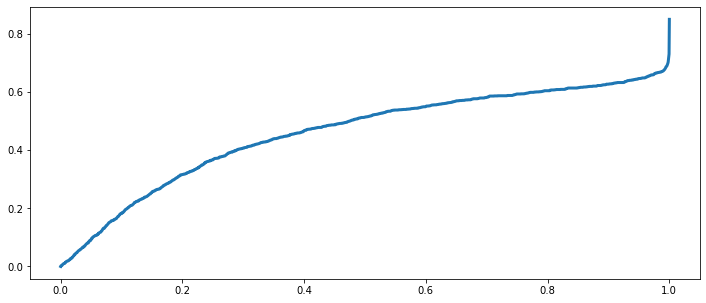

In [62]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(kde.support, kde.cdf, lw=3, label='CDF')